In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
from scipy import integrate
import matplotlib
from matplotlib import pyplot as plt
import ngfunction2

In [3]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=67, ombh2=0.022445, omch2=0.143648-0.022445)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
pars.InitPower.set_params(As=1.7195e-9,ns=0.96)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.96
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 1.7195e-09
 At = 1.0
 

In [4]:
zetas= np.array([1,1.2,1.4,1.6])
pars.set_matter_power(redshifts=zetas, kmax=1.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

Note: redshifts have been re-sorted (earliest first)


In [5]:
kh, z, pk = results.get_matter_power_spectrum(minkh=2e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza
z

[1.0, 1.2, 1.4, 1.6]

In [6]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [7]:
z = np.array(z)

In [8]:
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(np.ones(len(z))+z)**3/(H(z)/H0)**2 #densità di materia a diverso z
omz

array([0.78738482, 0.83044894, 0.86320678, 0.88827296])

Derivata composta della distanza di luminosità

dr/dz =  c/H

dl = (1+z)*r 

dl'= r + (1+z)*c/H

In [9]:
bias = np.empty(len(zetas))
for i in range (len(zetas)):
    bias[i]= ngfunction2.b(z[i]) 

f = (results.get_fsigma8()/results.get_sigma8())
f = np.flipud(f)


dl = results.luminosity_distance(z[0])
d = results.comoving_radial_distance(z[0])
 
fl= (2*d/(np.ones(len(z))+z))/(np.ones(len(z))*d+(np.ones(len(z))+z)*2.99e5/H(z))

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati


In [10]:
DeltaZ = np.array([0.05,0.1,0.2,0.3,0.5]) 
dN= np.empty(1000)


#calcolo la desnità di galassie a diversi bin di redshift
ng = np.empty((len(zetas),len(DeltaZ)))

for i in range (len(zetas)):
   for j in range(len(DeltaZ)):
      start = z[i]-DeltaZ[j]/2
      stop = z[i]+DeltaZ[j]/2
      x = np.linspace(start,stop, 1000)

      for k in range (len(x)):
         dN[k] = ngfunction2.dNdz(x[k])*results.h_of_z(x[k])/(dist(x[k])**2)
      ng[i][j]= integrate.trapezoid(dN,x)

#plt.plot(x,dNdz)
ngw = ng

In [11]:
ng[:,2]

array([0.00051956, 0.00042249, 0.00031843, 0.00019932])

In [12]:
#Distribuzione di galassie e sorgenti di onde gravitazionali, calcolo di prova


ng1 = np.empty(len(zetas))
for i in range (len(zetas)):
    ng1[i]= ngfunction2.Ng(z[i])*10**-4*h**3   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)

ngw1 = ng1
ng1


array([0.00056743, 0.00046155, 0.00034823, 0.00021589])

In [13]:
#Calcolo dei modi normali
DeltaMu = np.abs(mu[0]-mu[1])
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= 2* np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= 2*np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    


Vol = np.empty((len(zetas),len(DeltaZ)))
#for i in range (len(zetas)):
#    Vol[i]= ngfunction2.Vol(z[3])*h**(-3) 
for i in range (len(DeltaZ)):
    Vol[:,i] = 4./3.*np.pi*((dist(z+np.ones(len(zetas))*DeltaZ[i]/2))**3-(dist(z-np.ones(len(zetas))*DeltaZ[i]/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

N = np.empty((len(kh),len(mu),len(zetas),len(DeltaZ)))
for j in range(len(kh)):
    for i in range (len(zetas)):
        for k in range (len(DeltaZ)):
            N[j,:,i,k]= Vol[i,k]/(2*np.pi)**3 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu


In [14]:
kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

array([0.03392691, 0.016961  , 0.0084756 , 0.00564496, 0.00337662])

# CALCOLO CON LE ONDE GRAVITAZIONALI

In [15]:
#Set di dati simulati spettro di potenza delle galassie per onde gravitazionali

Pgg = np.empty((len(kh),len(mu),len(zetas)))
for i in range (len(kh)):
    for j in range (len(mu)):
        for m in range (len(zetas)):
            Pgg[i][j][m] = float((bias[m] + fl[m] *f[m] * mu[j]**2)**2*pk[m,i])


In [16]:
##Errori dei dati simulati
err_Pgg = np.empty((len(kh),len(mu),len(zetas),len(DeltaZ)))
for i in range (len(kh)):
    for j in range (len(mu)):
        for k in range (len(zetas)):
            for l in range (len(DeltaZ)):
                err_Pgg[i][j][k][l] = np.sqrt(2/N[i][j][k][l])*(Pgg[i][j][k]+1/ngw[k][l])
            


In [17]:
gammas= np.linspace(-0.5,1.5,num = 200)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)


chi2 = np.zeros((len(gammas),len(zetas), len(DeltaZ)))

for k,gamma in enumerate(gammas):
    for m in range (len(zetas)):
        for l in range (len(DeltaZ)):
            for i in range (len(kh)):
                for j in range (len(mu)):
                    chi2[k,m,l]= chi2[k,m,l]+(float((bias[m] + (omz[m]**gamma)*fl[m] * (mu[j])**2)**2*pk[m,i]) - Pgg[i][j][m])**2/err_Pgg[i][j][m][l]**2
        


C:\Users\sarev\AppData\Local\Temp\ipykernel_16068\4219569364.py:2: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  interpol= np.empty((len(zetas),len(DeltaZ)), dtype=interpolate.interpolate.interp1d)


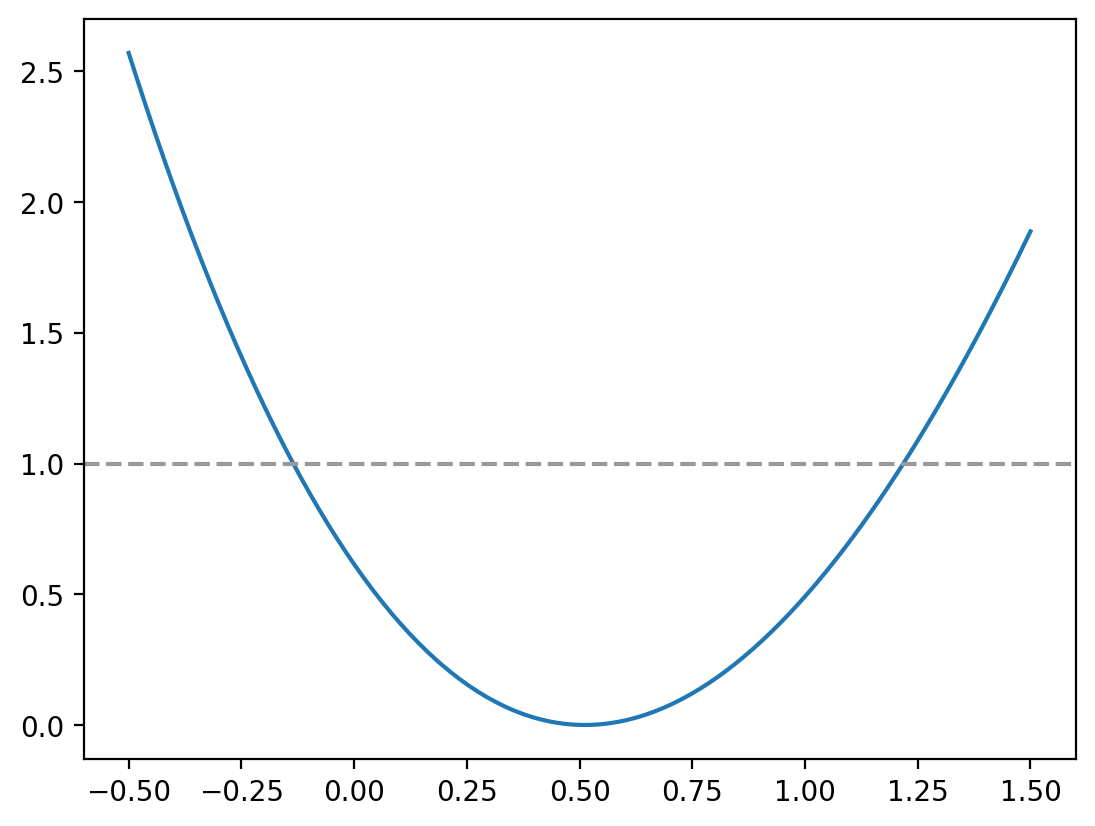

In [18]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol= np.empty((len(zetas),len(DeltaZ)), dtype=interpolate.interpolate.interp1d)
for i in range (len(zetas)):
    for l in range (len(DeltaZ)):
        interpol[i,l] =  interpolate.interp1d(gammas,chi2[:,i,l],kind='cubic')

plt.plot(gammas, interpol[3,0](gammas), '-')
#plt.legend(['data', 'cubic'])
#plt.DeltaZlabel(' gamma ')
#plt.ylabel('Chi^2')

#RETTA PER GLI ERRORI
plt.axhline(y=1, linestyle= 'dashed',color = '0.6', label = 'intervallo di confidenza del 68%' )

#plt.axis([0.3,0.7,0,3])


In [19]:
#TRASFORMO IN  FUNZIONI
y = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for j in range (len(DeltaZ)):
    for i in range (len(zetas)):
        def y_(x):
            return interpol[i,j](x)
        y[i][j] = y_



In [20]:
#TROVO IL MINIMO DELLA FUNZIONE
minimo = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
min= [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
chi2min = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        minimo[i][j]=(optimize.least_squares(y[i][j],0.53))
        min[i][j]=(float(minimo[i][j].x))
        chi2min[i][j]=(y[i][j](min[i][j]))


In [21]:
#TROVO INTERSEZIONE CON LA RETTA DEGLI ERRORI
y1 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
intersec1 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
intersec2 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        y1[i][j]=lambda x: interpol[i,j](x) - 1 -chi2min[i][j]
        
for i in range (len(zetas)):
    for j in range (len(DeltaZ)):  
        intersec1[i][j]=(optimize.brentq(y1[i][j],-0.5,min[i][j]))
        intersec2[i][j]=(optimize.brentq(y1[i][j],min[i][j],1.5))    #trova le soluzioni in un intervallo fissato




In [22]:
#TROVO GLI ERRORI
sigmad = np.zeros((len(zetas),len(DeltaZ)))
sigmas = np.zeros((len(zetas),len(DeltaZ)))

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        sigmad[i][j]=np.abs(min[i][j]-intersec1[i][j])

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        sigmas[i][j]=np.abs(min[i][j]-intersec2[i][j])

sigma = (sigmas + sigmad)/2


In [23]:
print(min[2][2],sigma[2,2])

0.5186329975847274 0.06625375047523002


# CALCOLO CON IL REDSHIFT

In [24]:
#Set di dati simulati spettro di potenza delle galassie per onde gravitazionali

Pgg2 = np.empty((len(kh),len(mu),len(zetas)))
for m in range (len(zetas)):
    for i in range (len(kh)):
        for j in range (len(mu)):
            Pgg2[i][j][m] = float((bias[m] + f[m] * mu[j]**2)**2*pk[m,i])


In [25]:
#Errori spettro di potenza, solo seconda parte perché la prima è uguale

err_Pgg2 = np.empty((len(kh),len(mu),len(zetas),len(DeltaZ)))
for i in range (len(kh)):
    for j in range (len(mu)):
        for m in range (len(zetas)):
            for l in range (len(DeltaZ)):
                err_Pgg2[i][j][m][l] = np.sqrt(2/N[i][j][m][l])*(Pgg[i][j][m]+1/ng[m][l])

In [26]:
gammas= np.linspace(0,1,num = 120)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi22 = np.zeros((len(gammas),len(zetas),len(DeltaZ)))

for k,gamma in enumerate(gammas):
    for m in range (len(zetas)):
        for i in range (len(kh)):
            for j in range (len(mu)):
                for l in range (len(DeltaZ)):
                    chi22[k,m,l]= chi22[k,m,l]+(float((bias[m] + (omz[m]**gamma) * (mu[j])**2)**2*pk[m,i]) - Pgg2[i][j][m])**2/err_Pgg2[i][j][m][l]**2

C:\Users\sarev\AppData\Local\Temp\ipykernel_16068\2710581604.py:2: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  interpol2= np.empty((len(zetas),len(DeltaZ)), dtype=interpolate.interpolate.interp1d)


(0.4, 0.6, 0.0, 3.0)

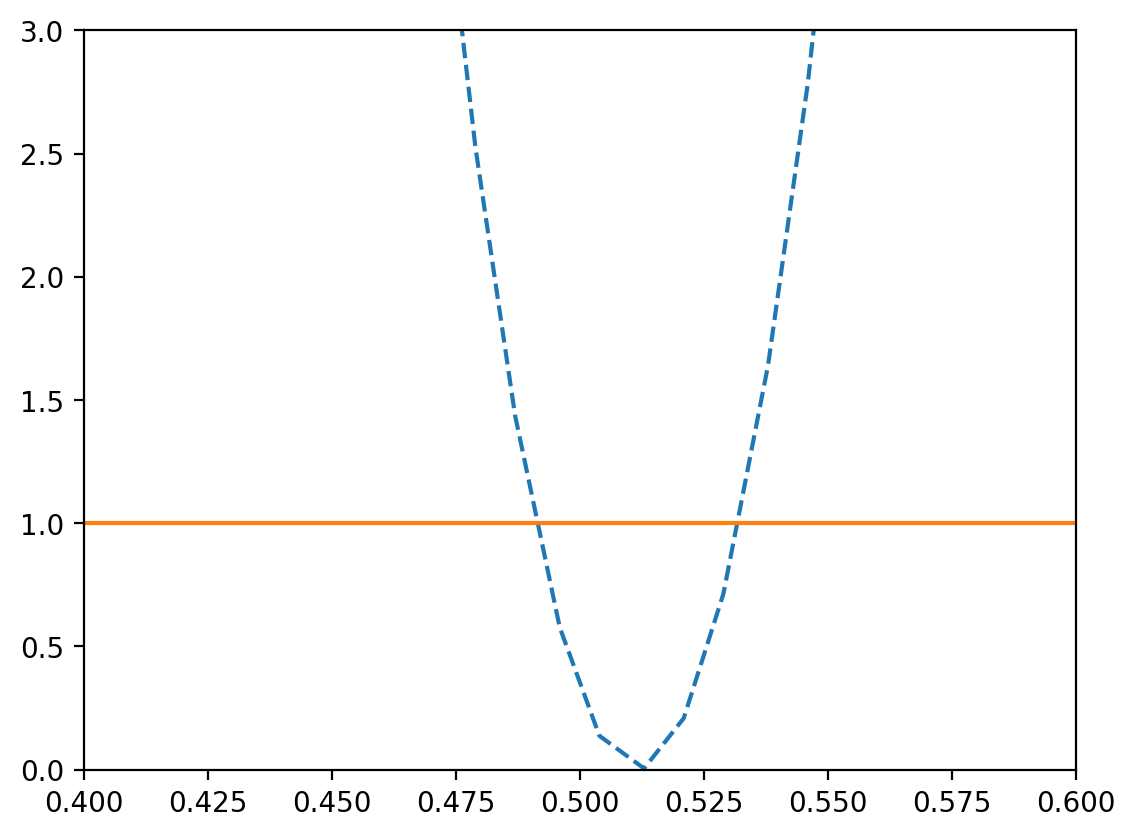

In [27]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol2= np.empty((len(zetas),len(DeltaZ)), dtype=interpolate.interpolate.interp1d)
for i in range (len(zetas)):
    for l in range (len(DeltaZ)):
        interpol2[i,l] =  interpolate.interp1d(gammas,chi22[:,i,l],kind='cubic')

plt.plot(gammas, interpol2[3,3](gammas), '--')
#plt.legend(['data', 'cubic'])
#plt.xlabel(' gamma ')
#plt.ylabel('Chi^2')

#RETTA PER GLI ERRORI
xpoints= np.arange(-1,3,0.005)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)

plt.axis([0.4,0.6,0,3])


In [28]:
#TRASFORMO IN  FUNZIONI
y2 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
for i in range (len(zetas)):
    for l in range (len(DeltaZ)):
        def y_(x):
            return interpol2[i,l](x)
        y2[i][l]=y_

In [29]:
#TROVO IL MINIMO DELLA FUNZIONE
minimo2 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
min2= [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
chi2min2 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        minimo2[i][j] = (optimize.least_squares(y2[i][j],0.53))
        min2[i][j]= float(minimo2[i][j].x)
        chi2min2[i][j] = y2[i][j](min2[i][j])


In [30]:
#TROVO INTERSEZIONE CON LA RETTA DEGLI ERRORI
f2 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
intersec12 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
intersec22 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        f2[i][j] = lambda x: interpol2[i][j](x) - 1 -chi2min2[i][j]
    
for i in range (len(zetas)):  
    for j in range (len(DeltaZ)):
        intersec12[i][j] = optimize.brentq(f2[i][j],0,min2[i][j])
        intersec22[i][j] = optimize.brentq(f2[i][j],min2[i][j],1)  #trova le soluzioni in un intervallo fissato




In [31]:
#TROVO GLI ERRORI
sigmad2 = np.zeros((len(zetas),len(DeltaZ)))
sigmas2 = np.zeros((len(zetas),len(DeltaZ)))

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        sigmad2[i,j]=np.abs(min2[i][j]-intersec12[i][j])

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        sigmas2[i,j]=np.abs(min2[i][j]-intersec22[i][j])

sigma2 = (sigmas2 + sigmad2)/2


In [32]:
print(min2[2][2],sigma2[2][2])

0.5185916157725989 0.018941930181910205


# CALCOLO CROSS CORRELATION

In [33]:
Pgg3 = np.empty((len(kh),len(mu),len(zetas)))
for m in range (len(zetas)):
    for i in range (len(kh)):
        for j in range (len(mu)):
            Pgg3[i][j][m] = float((bias[m] + fl[m] *f[m] * mu[j]**2)*(bias[m] + f[m] * mu[j]**2)*pk[m,i])

In [34]:
#Errori spettro di potenza, solo seconda parte perché la prima è uguale

err_Pgg3 = np.empty((len(kh),len(mu),len(zetas),len(DeltaZ)))
for i in range (len(kh)):
    for j in range (len(mu)):
        for k in range (len(zetas)):
            for l in range (len(DeltaZ)):
                err_Pgg3[i][j][k][l] = np.sqrt( (Pgg3[i][j][k]**2 + (Pgg2[i][j][k]+1/ng[k][l]) * (Pgg[i][j][k]+1/ngw[k][l])) /N[i][j][k][l])


In [35]:
gammas= np.linspace(0,1,num = 150)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)



chi23 = np.zeros((len(gammas),len(zetas), len(DeltaZ)))

for k,gamma in enumerate(gammas):
    for m in range (len(zetas)):
        for l in range (len(DeltaZ)):
            for i in range (len(kh)):
                for j in range (len(mu)):
                    chi23[k,m,l]= chi23[k,m,l]+float(((bias[m] + (omz[m]**gamma)*fl[m] * (mu[j])**2)*(bias[m] + (omz[m]**gamma)* (mu[j])**2)*pk[m,i]) - Pgg3[i][j][m])**2/err_Pgg3[i][j][m][l]**2


C:\Users\sarev\AppData\Local\Temp\ipykernel_16068\3278262315.py:2: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  interpol3= np.empty((len(zetas),len(DeltaZ)), dtype=interpolate.interpolate.interp1d)


AttributeError: 'list' object has no attribute 'set_figheight'

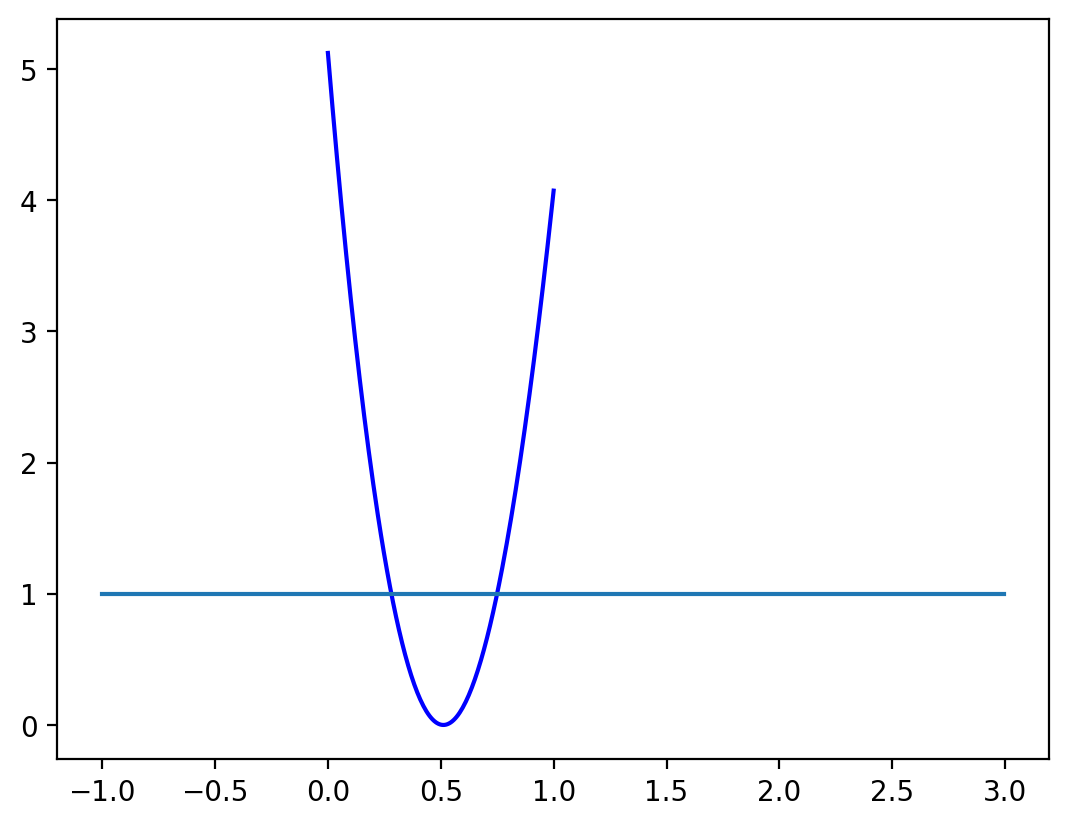

In [68]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol3= np.empty((len(zetas),len(DeltaZ)), dtype=interpolate.interpolate.interp1d)
for i in range (len(zetas)):
    for l in range (len(DeltaZ)):
        interpol3[i,l] =  interpolate.interp1d(gammas,chi23[:,i,l],kind='cubic')

#plt.plot(gammas, interpol3[3,3](gammas), '--',color = 'r')
fig=plt.plot(gammas, interpol3[3,0](gammas), '-', color= 'b')
#plt.legend(['data', 'cubic'])
#plt.xlabel(' gamma ')
#plt.ylabel('Chi^2')

#RETTA PER GLI ERRORI
xpoints= np.arange(-1,3,0.005)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)

#plt.axis([0.4,0.6,0,8])



In [37]:
y3 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for j in range (len(DeltaZ)):
    for i in range (len(zetas)):
        def y_(x):
            return interpol3[i,j](x)
        y3[i][j] = y_


In [38]:
#TROVO IL MINIMO DELLA FUNZIONE
minimo3 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
min3= [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
chi2min3 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        minimo3[i][j]=(optimize.least_squares(y3[i][j],0.5))
        min3[i][j]=(float(minimo3[i][j].x))
        chi2min3[i][j]=(y[i][j](min3[i][j]))

In [39]:
#TROVO INTERSEZIONE CON LA RETTA DEGLI ERRORI
f3 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
intersec13 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]
intersec23 = [[0 for x in range(len(DeltaZ))] for x in range(len(zetas))]

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        f3[i][j]=lambda x: interpol3[i,j](x) - 1 -chi2min3[i][j]
        
for i in range (len(zetas)):
    for j in range (len(DeltaZ)):  
        intersec13[i][j]=(optimize.brentq(f3[i][j],0,min3[i][j]))
        intersec23[i][j]=(optimize.brentq(f3[i][j],min3[i][j],1))    #trova le soluzioni in un intervallo fissato



In [40]:
sigmad3 = np.zeros((len(zetas),len(DeltaZ)))
sigmas3 = np.zeros((len(zetas),len(DeltaZ)))

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        sigmad3[i][j]=np.abs(min3[i][j]-intersec13[i][j])

for i in range (len(zetas)):
    for j in range (len(DeltaZ)):
        sigmas3[i][j]=np.abs(min3[i][j]-intersec23[i][j])

sigma3 = (sigmas3 + sigmad3)/2
print(sigma[0,0]) 
print(sigma[0,3])


0.12139041733841627
0.01964117335435106


# GRAFICI DI CONFRONTO

In [41]:
perc = DeltaZ
extent = np.min(perc), np.max(perc), np.max(zetas), np.min(zetas)

In [42]:
sigma2

array([[0.04051798, 0.01846132, 0.00933631, 0.00658059, 0.00444282],
       [0.05976878, 0.02639762, 0.01290313, 0.00892251, 0.00589647],
       [0.09558674, 0.04057654, 0.01894193, 0.01274857, 0.00816543],
       [0.1810127 , 0.07290013, 0.03184938, 0.02056581, 0.0125342 ]])

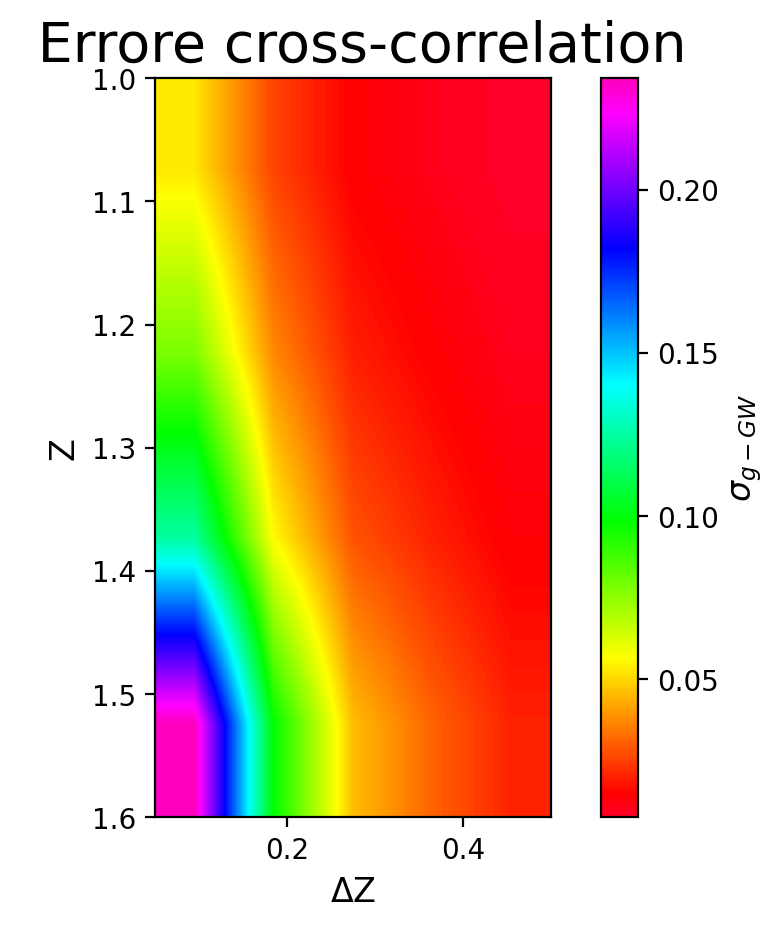

In [99]:

X, Y = np.meshgrid(perc, zetas)
#fig = plt.figure(frameon=False)
im1 = plt.imshow(sigma3, cmap ="gist_rainbow", interpolation ='bilinear', extent = extent,aspect=1.4)
plt.title(" Errore cross-correlation",size=20)
bar = plt.colorbar(im1)
plt.xlabel("$\Delta$Z",size=12)
plt.ylabel("Z",size=12)
bar.set_label("$\sigma_{g-GW}$",size=12)

In [74]:
def cm_to_inch(value):
    return value/2.54

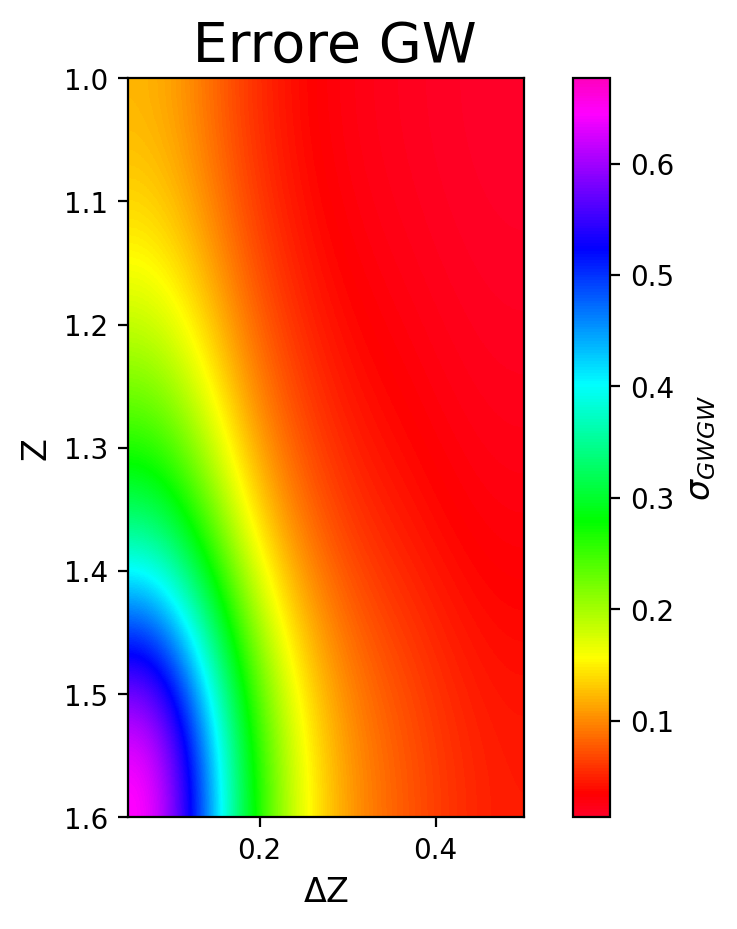

In [98]:
X, Y = np.meshgrid(perc, zetas)

#fig = plt.figure(figsize=(cm_to_inch(8), cm_to_inch(1)))
im2 = plt.imshow(sigma, cmap ="gist_rainbow", interpolation ='bicubic', extent = extent,aspect=1.4)
plt.title(" Errore GW",fontsize=20)
bar= plt.colorbar(im2)
plt.xlabel("$\Delta$Z",size=12)
plt.ylabel("Z",size=12)
bar.set_label("$\sigma_{GWGW}$",size=12)


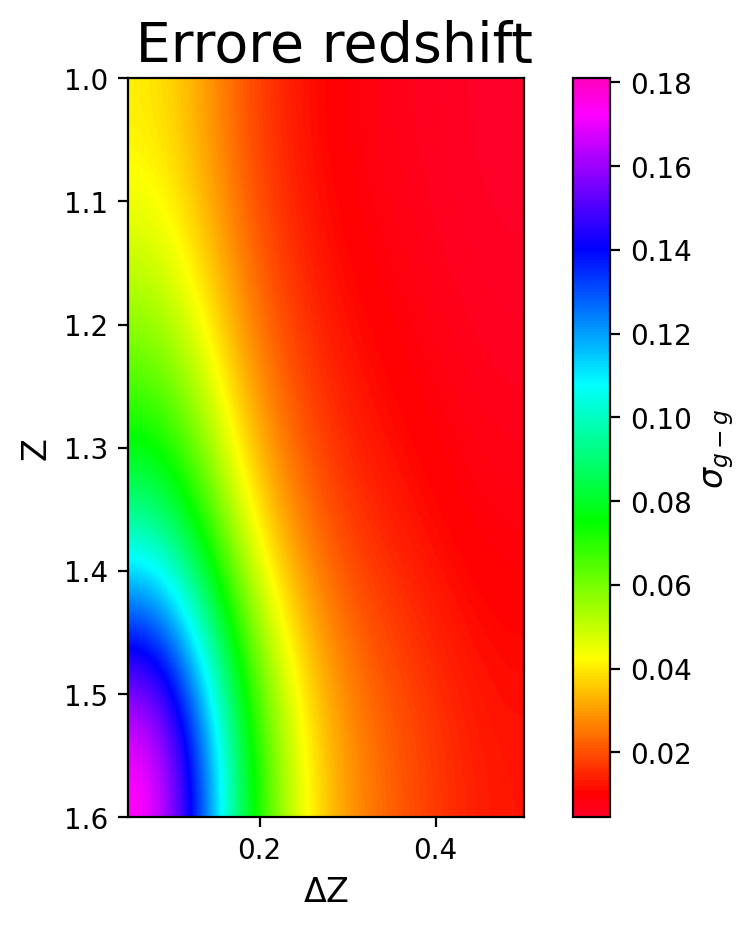

In [100]:
X, Y = np.meshgrid(perc, zetas)
#fig = plt.figure(frameon=False)
im2 = plt.imshow(sigma2, cmap ="gist_rainbow", interpolation ='bicubic', extent = extent,aspect=1.4)
plt.title(" Errore redshift",fontsize=20)
bar = plt.colorbar(im2)
plt.xlabel("$\Delta$Z",size=12)
plt.ylabel("Z",size=12)
bar.set_label("$\sigma_{g-g}$",size=12)

